In [1]:
from history_loader import load_spot_history

In [ ]:
base = "/Users/colinweaver/Documents/Personal Projects/SurflineFetcher/forecasts/spot_5842041f4e65fad6a7708827"
spot_id = "5842041f4e65fad6a7708827"

history = load_spot_history(base, spot_id)

surf_tree = history.surf

# Example: list issue dates & some lead times
# for issue_date, lead_map in surf_tree.items():
#     print("Issue:", issue_date, " → available lead_hours:", sorted(lead_map.keys())[:10])

# Example: get the 24h-ahead forecast from a given issue_date
issue = max(surf_tree.keys())  # latest forecast run
sp_24 = surf_tree[issue].get(24)
print(sp_24)

Issue: 2023-11-18 00:00:00+00:00  → available lead_hours: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Issue: 2023-11-19 00:00:00+00:00  → available lead_hours: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Issue: 2023-11-20 00:00:00+00:00  → available lead_hours: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Issue: 2023-11-21 00:00:00+00:00  → available lead_hours: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Issue: 2023-11-22 00:00:00+00:00  → available lead_hours: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Issue: 2023-11-23 00:00:00+00:00  → available lead_hours: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Issue: 2023-11-24 00:00:00+00:00  → available lead_hours: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Issue: 2023-11-25 00:00:00+00:00  → available lead_hours: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Issue: 2023-11-26 00:00:00+00:00  → available lead_hours: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Issue: 2023-11-27 00:00:00+00:00  → available lead_hours: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Issue: 2023-11-28 00:00:00+00:

[warn] no matches for lead=6h (tol=3h)
[warn] no matches for lead=12h (tol=3h)
[warn] no matches for lead=24h (tol=6h)
   lead_hours  mae  rmse  bias  mape_percent  directional_accuracy  n_pairs
0         168  0.0   0.0   0.0           0.0                   1.0    17569
1         384  0.0   0.0   0.0           0.0                   1.0    14164


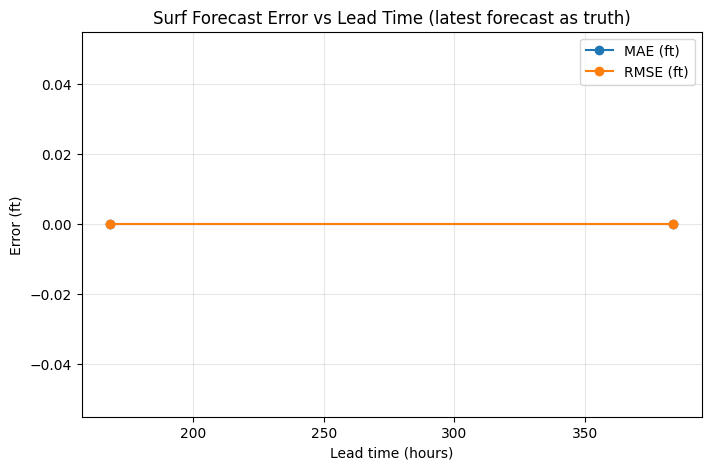

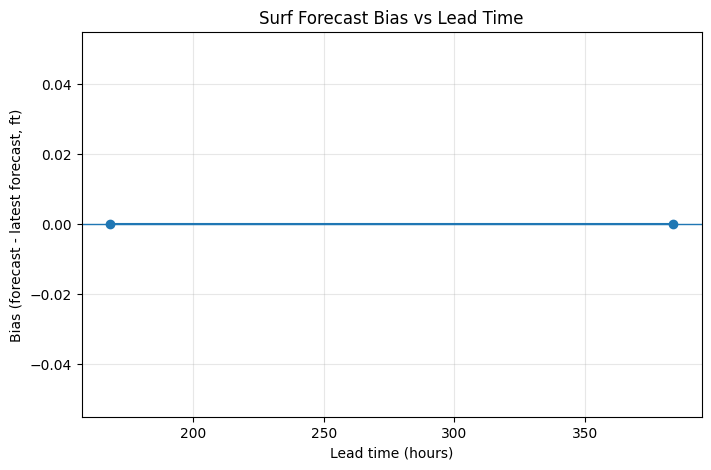

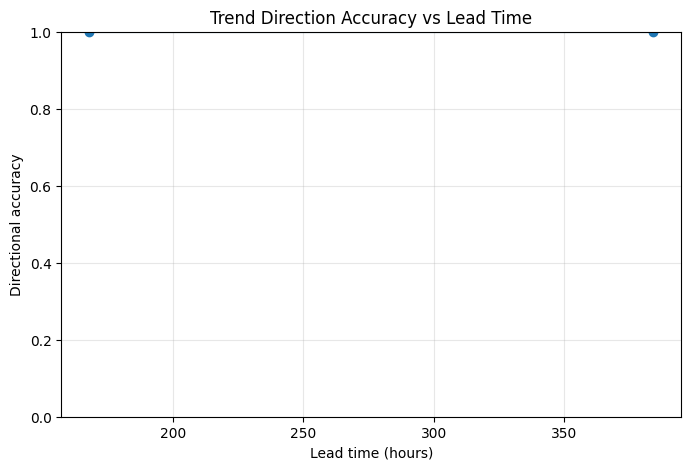

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 1. Convert surf_tree → long DataFrame
# -----------------------------------------------------------

def surf_tree_to_df(surf_tree) -> pd.DataFrame:
    rows = []
    for issue_date, lead_map in surf_tree.items():
        for lead_h, sp in lead_map.items():
            rows.append(
                {
                    "timestamp": sp.timestamp,
                    "issue_date": sp.issue_date,
                    "lead_hours": sp.lead_hours,
                    "surf_min": sp.surf_min,
                    "surf_max": sp.surf_max,
                    "surf_humanRelation": sp.surf_humanRelation,
                }
            )
    df = pd.DataFrame(rows)
    # Clean up types
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["issue_date"] = pd.to_datetime(df["issue_date"], utc=True)
    df["lead_hours"] = df["lead_hours"].astype(int)
    df["surf_max"] = pd.to_numeric(df["surf_max"], errors="coerce")
    return df.dropna(subset=["timestamp", "issue_date", "surf_max"])


df = surf_tree_to_df(surf_tree)

# Only forecasts made before (or at) the event
df = df[df["lead_hours"] >= 0].copy()

# -----------------------------------------------------------
# 2. Define "truth" = latest available forecast for each timestamp
# -----------------------------------------------------------
df_sorted = df.sort_values(["timestamp", "issue_date"])

# Mark truth rows: max issue_date per timestamp
idx_truth = df_sorted.groupby("timestamp")["issue_date"].idxmax()
df_sorted["is_truth"] = False
df_sorted.loc[idx_truth, "is_truth"] = True

truth_df = df_sorted.loc[df_sorted["is_truth"], ["timestamp", "surf_max"]].rename(
    columns={"surf_max": "truth_height"}
)

# -----------------------------------------------------------
# 3. Helper: get forecasts closest to a target lead time (excluding truth)
# -----------------------------------------------------------
def get_forecasts_for_lead(df_all: pd.DataFrame,
                           target_hours: float,
                           tol_hours: float) -> pd.DataFrame:
    """
    For each timestamp, pick the forecast (NOT the truth row) whose lead_hours
    is closest to target_hours within ±tol_hours.
    """
    df = df_all[~df_all["is_truth"]].copy()
    df["lead_diff"] = (df["lead_hours"] - target_hours).abs()
    df = df[df["lead_diff"] <= tol_hours]

    if df.empty:
        return pd.DataFrame(columns=["timestamp", "forecast_height", "lead_hours"])

    df = df.sort_values(["timestamp", "lead_diff"])
    df = df.groupby("timestamp", as_index=False).first()

    return df[["timestamp", "surf_max", "lead_hours"]].rename(
        columns={"surf_max": "forecast_height"}
    )


# Lead times (hours) and tolerances
lead_specs = {
    6: 3,       # ±3h
    12: 3,      # ±3h
    24: 6,      # ±6h
    168: 12,    # 7 days ±12h
    384: 12,    # 16 days ±12h
}

# -----------------------------------------------------------
# 4. Compute metrics for each lead time
# -----------------------------------------------------------
metrics = []

for lead, tol in lead_specs.items():
    fc_df = get_forecasts_for_lead(df_sorted, lead, tol)
    merged = fc_df.merge(truth_df, on="timestamp", how="inner")

    if merged.empty:
        print(f"[warn] no matches for lead={lead}h (tol={tol}h)")
        continue

    # --- Error calculations ---
    err = merged["forecast_height"] - merged["truth_height"]
    abs_err = err.abs()
    sq_err = err ** 2

    # Relative error (%), avoid division by zero
    truth = merged["truth_height"]
    with np.errstate(divide="ignore", invalid="ignore"):
        rel_err = abs_err / truth.replace(0, np.nan)

    mae = abs_err.mean()
    rmse = np.sqrt(sq_err.mean())
    bias = err.mean()
    mape = rel_err.mean() * 100.0  # percent

    # --- Directional correctness ---
    merged_sorted = merged.sort_values("timestamp").reset_index(drop=True)
    truth_next = merged_sorted["truth_height"].shift(-1)
    forecast_next = merged_sorted["forecast_height"].shift(-1)

    truth_trend = truth_next - merged_sorted["truth_height"]
    forecast_trend = forecast_next - merged_sorted["forecast_height"]

    sign_truth = np.sign(truth_trend)
    sign_fore = np.sign(forecast_trend)

    mask = (
        truth_next.notna()
        & forecast_next.notna()
        & (sign_truth != 0)  # ignore flat truth
    )

    if mask.any():
        directional_accuracy = (sign_truth[mask] == sign_fore[mask]).mean()
    else:
        directional_accuracy = np.nan

    metrics.append(
        {
            "lead_hours": lead,
            "mae": mae,
            "rmse": rmse,
            "bias": bias,
            "mape_percent": mape,
            "directional_accuracy": directional_accuracy,
            "n_pairs": len(merged),
        }
    )

metrics_df = pd.DataFrame(metrics).sort_values("lead_hours")
print(metrics_df)

# -----------------------------------------------------------
# 5. Plots
# -----------------------------------------------------------

# A. MAE & RMSE vs lead time
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["lead_hours"], metrics_df["mae"], marker="o", label="MAE (ft)")
plt.plot(metrics_df["lead_hours"], metrics_df["rmse"], marker="o", label="RMSE (ft)")
plt.xlabel("Lead time (hours)")
plt.ylabel("Error (ft)")
plt.title("Surf Forecast Error vs Lead Time (latest forecast as truth)")
plt.grid(True, alpha=0.3)
plt.legend()

# B. Bias vs lead time
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["lead_hours"], metrics_df["bias"], marker="o")
plt.axhline(0, linewidth=1)
plt.xlabel("Lead time (hours)")
plt.ylabel("Bias (forecast - latest forecast, ft)")
plt.title("Surf Forecast Bias vs Lead Time")
plt.grid(True, alpha=0.3)

# C. Directional accuracy vs lead time
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["lead_hours"], metrics_df["directional_accuracy"], marker="o")
plt.xlabel("Lead time (hours)")
plt.ylabel("Directional accuracy")
plt.ylim(0, 1)
plt.title("Trend Direction Accuracy vs Lead Time")
plt.grid(True, alpha=0.3)

plt.show()